In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

from utils.visualize import *
from utils.FIR_filter import *
from utils.signal_process import *
from utils.preprocess import *
from utils.model import *
import utils.vision_transformer as VT

import torch
from torch.utils.data import Dataset, DataLoader

import pickle

## Step-by-Step Data Preprocessing Demo

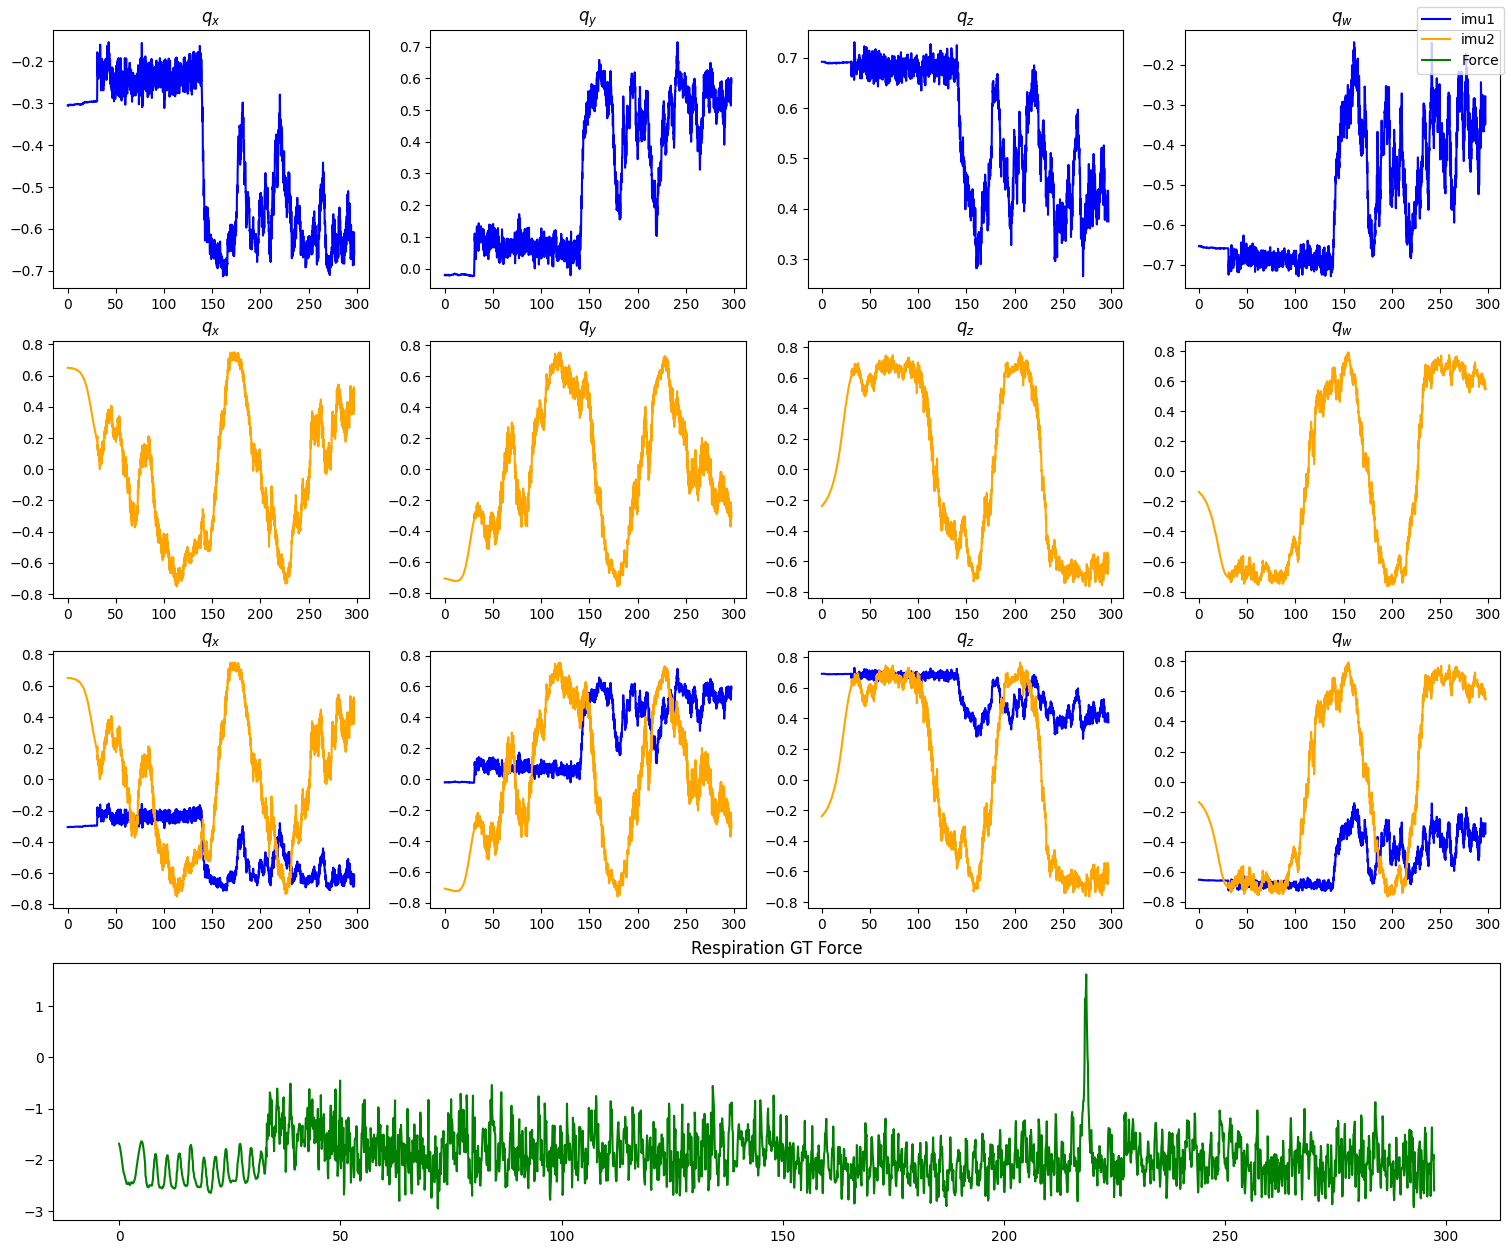

In [2]:
fs = 10
start_pt, end_pt = 0, -1
still_pt = 300 # 500

# file_path = "./data/8P/test/walk_0514_1043.csv"

# walk_0516_0644, *walk_0516_0650, *walk_0516_0701, walk_0516_0707, walk_0516_0713
# **run_0516_0735, *run_0516_0741, run_0516_0752, *run_0516_0807, run_0516_0812
action_name = "run_0516_0735"
file_path = f'./data/5_16/kiri/{action_name}.csv'

data = pd.read_csv(file_path)
data.columns = [
    "Timestamp",
    "imu1_q_x",
    "imu1_q_y",
    "imu1_q_z",
    "imu1_q_w",
    "imu2_q_x",
    "imu2_q_y",
    "imu2_q_z",
    "imu2_q_w",
    "Force",
    "RR",
]
sensor_names=['imu1','imu2']
cols = ['q_x', 'q_y', 'q_z', 'q_w']
data = data.iloc[start_pt:end_pt]

data = align_delay(data, delay=10)
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.set_index("Timestamp")

draw_imu_curve(data, overlap=True, show_gt=True)
# draw_imu_curve(data, overlap=True, show_gt=False)

best_score/total: 44/300


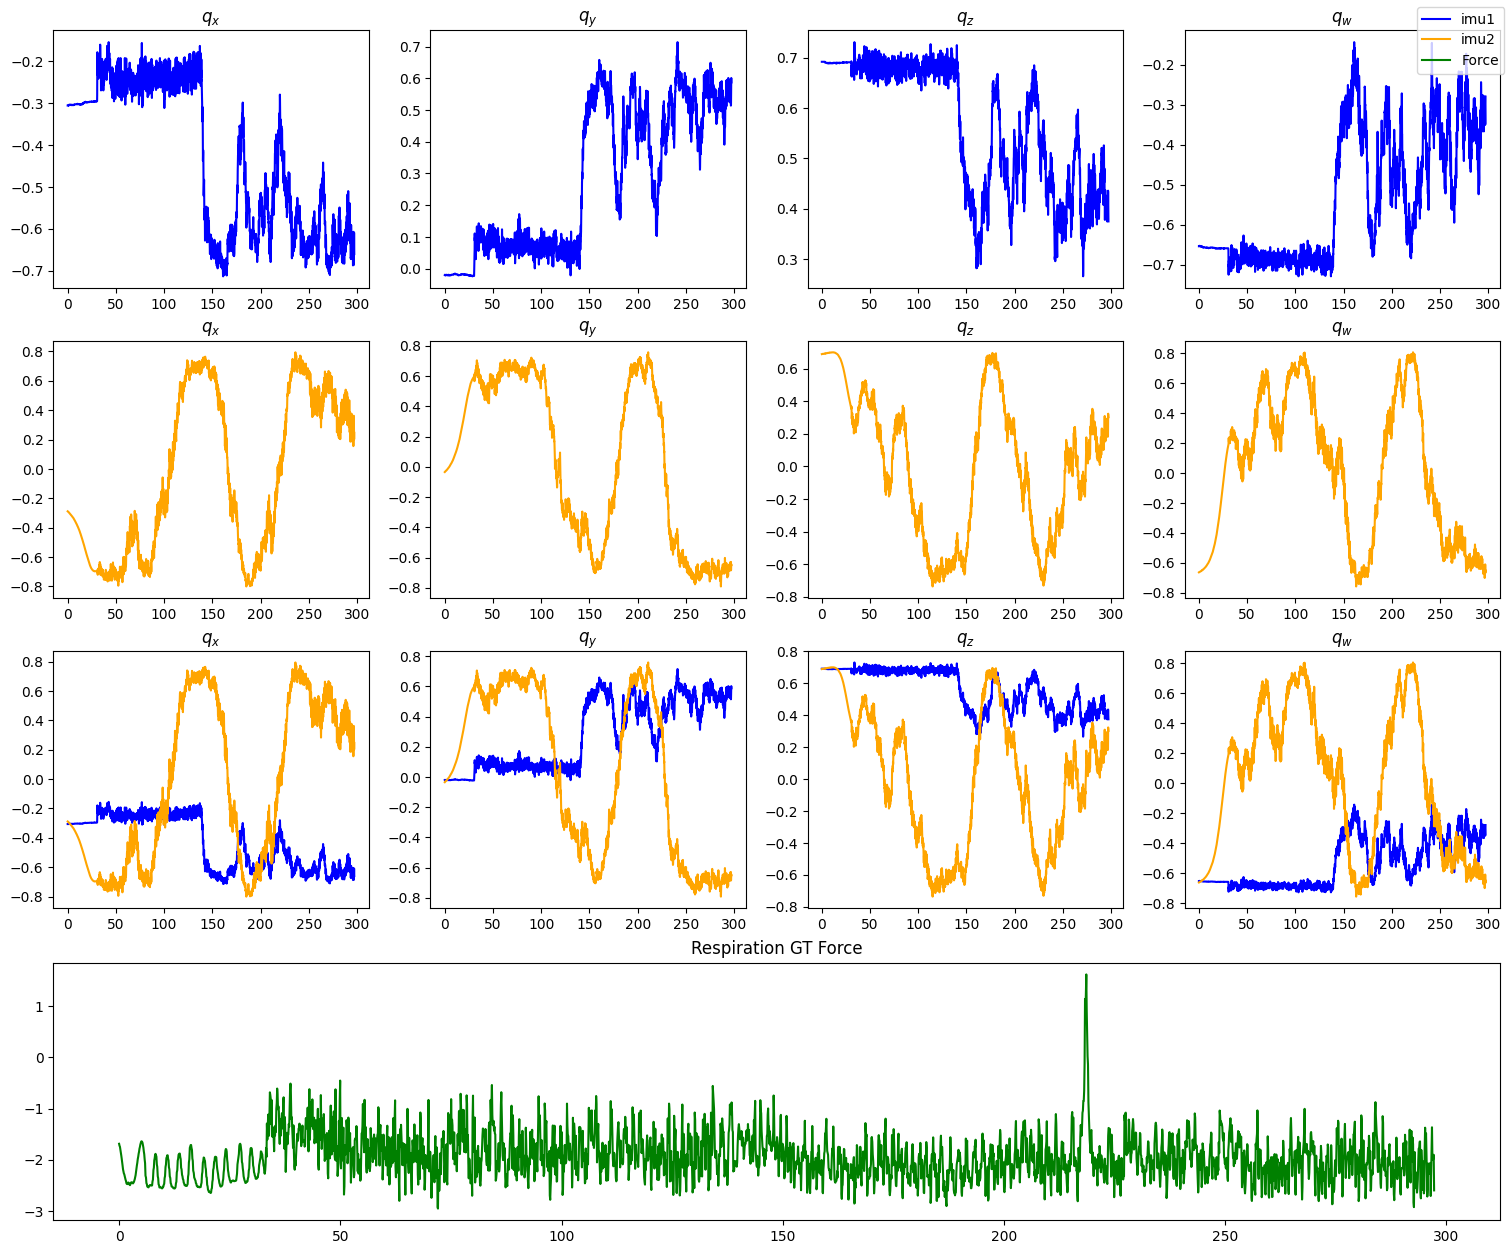

In [3]:
# Align IMUs (IMU2 -> IMU1)
q_corr = Q_RANSAC(data[0:still_pt], pool=1.0, d=0.05)

target, skew = 'imu1', 'imu2'
Q_skew = data[[skew + '_q_x', skew + '_q_y', skew + '_q_z', skew + '_q_w']].to_numpy()
Q_aligned = align_quaternion(q_corr, Q_skew) # (sample num, 4)
data_aligned = data.copy()

for i, col in enumerate(cols):
    data_aligned[[skew + '_' + col]] = Q_aligned[:, i].reshape(-1, 1)

draw_imu_curve(data_aligned, overlap=True, show_gt=True)

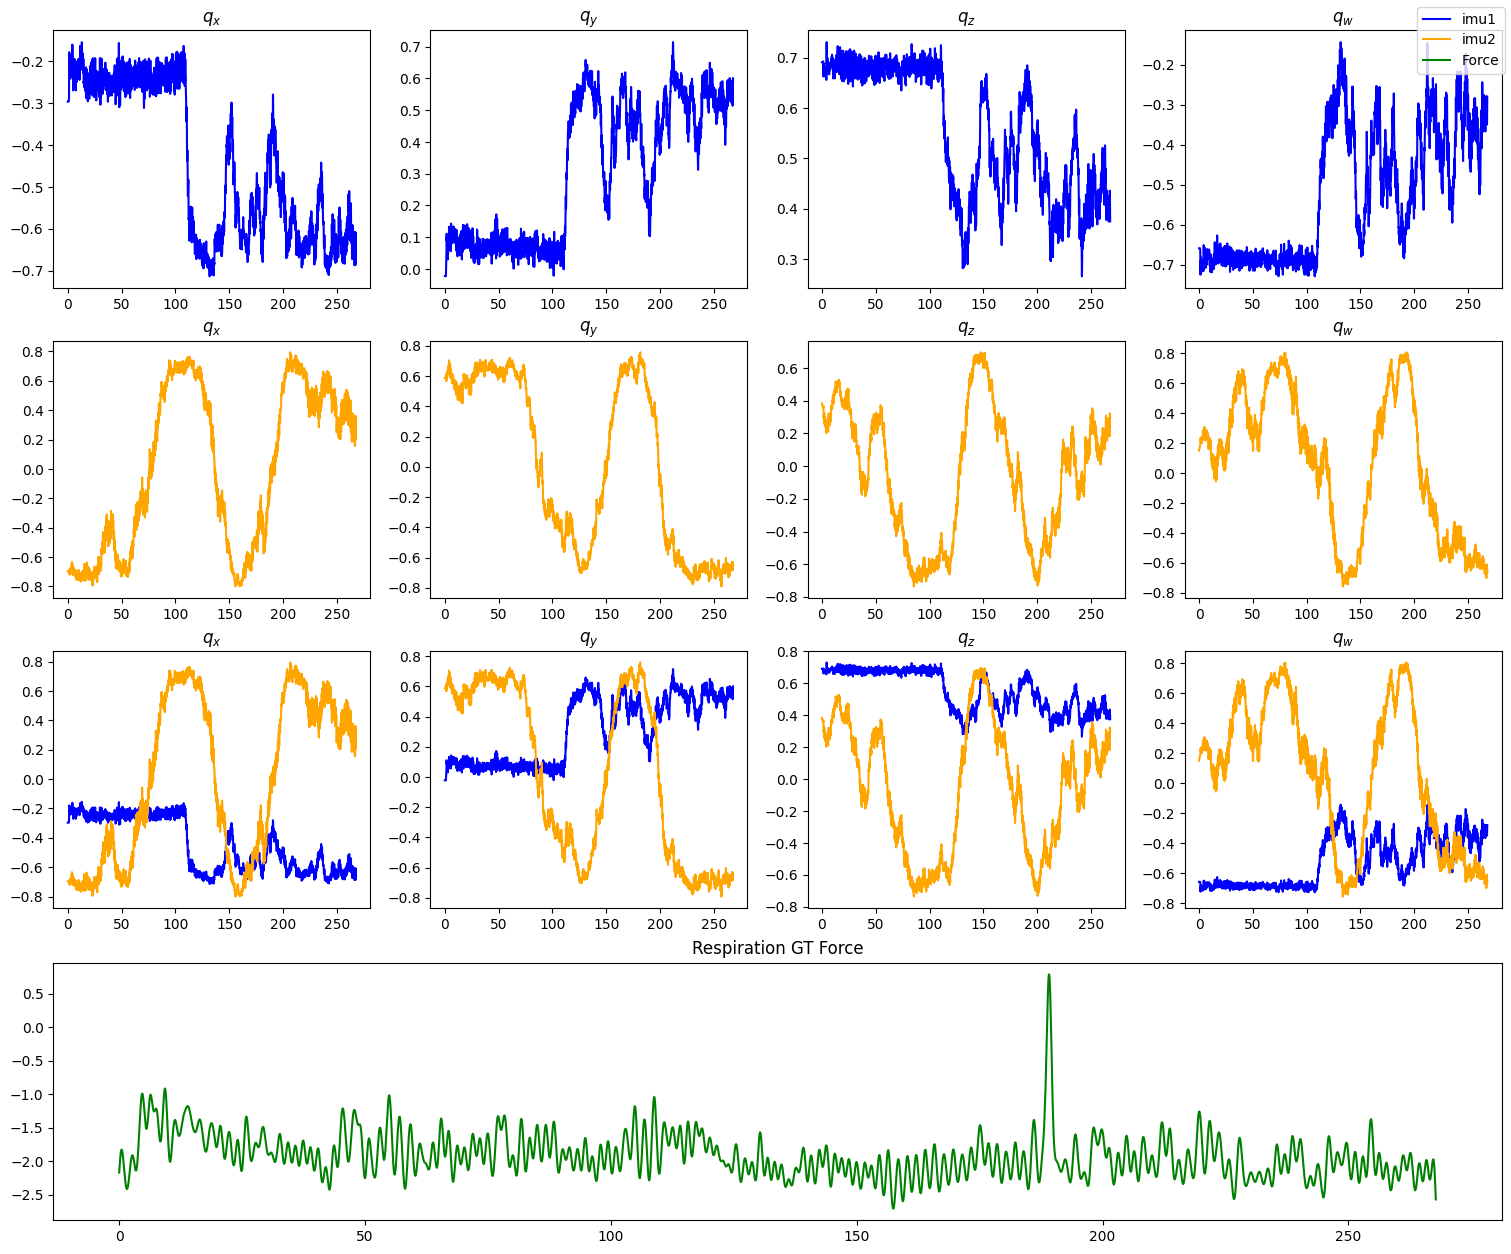

In [4]:
# Handle gt force
data_sp = data_aligned # data used in compute spectrogram shape
data_sp = data_sp[still_pt+0:]
cols = ['q_x', 'q_y', 'q_z', 'q_w'] # for quaternion

data_sp.loc[:, "Force"] = butter_filter(data_sp["Force"], cutoff=0.66)
draw_imu_curve(data_sp, overlap=True, show_gt=True)

## Compute Model Parameters (Spectrogram Shape)

In [6]:
# 1-D spectrogram
# window_size=128
# stride=64
# nperseg=128
# noverlap=64
# out1=True

# 2-D spectrogram
window_size=256
stride=64
nperseg=128
noverlap=64
out1=True
byCol=True
sp_num = 32

spectrograms_file, gts_file, times_file = prepare_file(file_path, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=out1, byCol=byCol, sp_num=sp_num)
dataset_file= IMUSpectrogramDataset(spectrograms_file, gts_file)
file_loader = DataLoader(dataset_file, batch_size=1, shuffle=False)

num_channels = spectrograms_file.shape[1]
num_freq_bins = spectrograms_file.shape[2]  # From computed spectrogram
num_time_steps = spectrograms_file.shape[3]  # From computed spectrogram

best_score/total: 44/300
----------------------------
sepctrograms:(40, 32, 65, 3)
gt:(40, 1)
times:(40, 1)


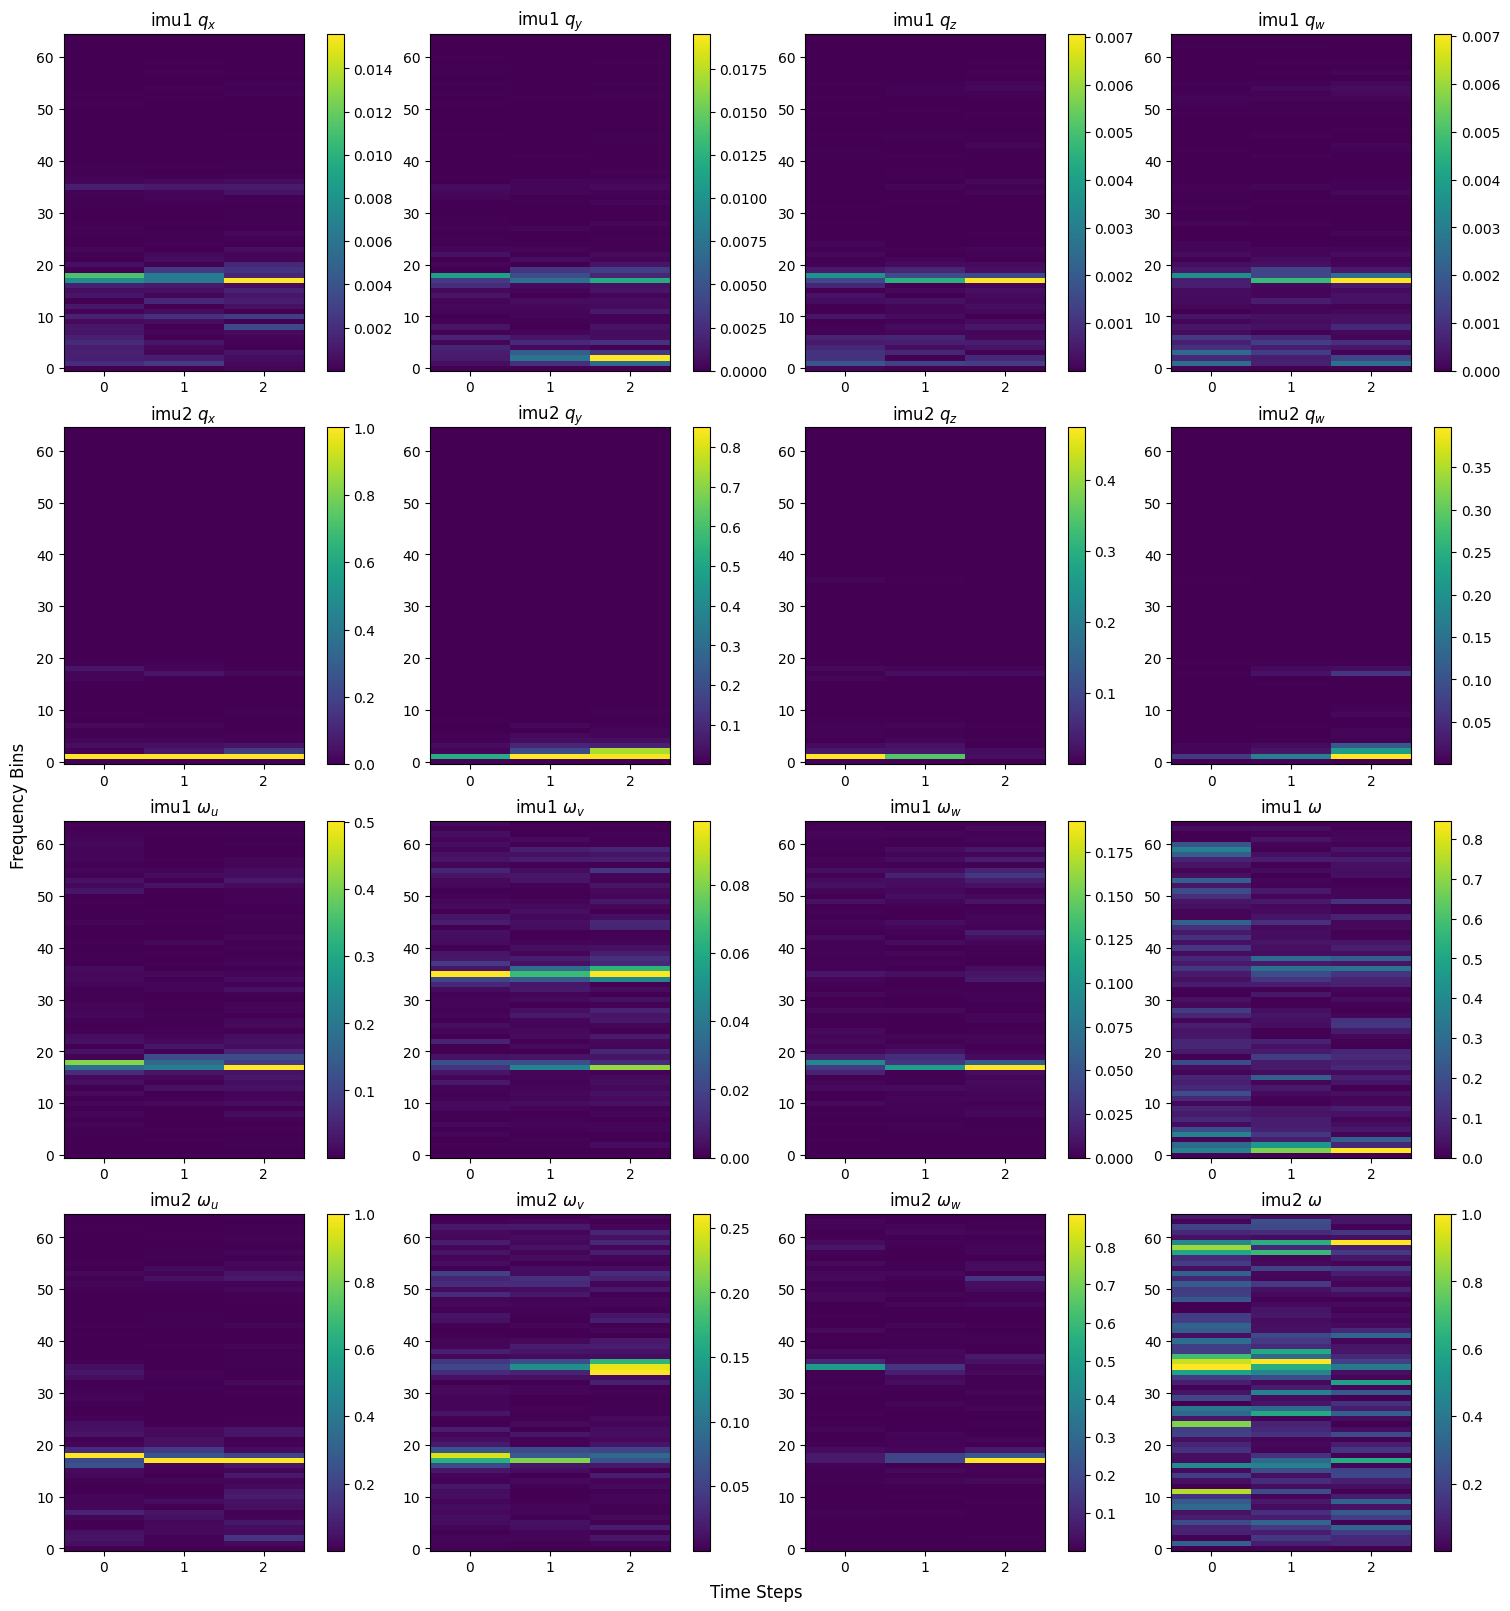

In [7]:
# show one spectrogram
plot_spectrogram_16(spectrograms_file[11])

In [8]:
torch.cuda.is_available()

True

## Testing Model

In [9]:
# Load dataset
dataset_dir = "dataset/"
dataset_name = "7.75P_32"
pkl_test = pickle.load(open(os.path.join(dataset_dir, f'{dataset_name}_test.pkl'), 'rb'))
input_test, gt_test = pkl_test['input'], pkl_test['gt']

print('Testing data......')
print(f'Testing shape: {input_test.shape}')

num_channels = input_test.shape[1]
num_freq_bins = input_test.shape[2]
num_time_steps = input_test.shape[3]

dataset_test = IMUSpectrogramDataset(input_test, gt_test)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=True)

Testing data......
Testing shape: (339, 32, 65, 3)


In [11]:
# Test one file
action_name = "walk_0520_1031" # sit_0514_1030, walk_0514_1043, walk_0520_0730, *walk_0520_0901, walk_0520_1031
path_file = f'./data/7.75P/test/{action_name}.csv'

# spectrograms_file, gts_file, times_file = prepare_file(path_file, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap)
spectrograms_file, gts_file, times_file = prepare_file(path_file, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=True, sp_num=sp_num)
dataset_file= IMUSpectrogramDataset(spectrograms_file, gts_file)
file_loader = DataLoader(dataset_file, batch_size=1, shuffle=False)

best_score/total: 118/300
----------------------------
sepctrograms:(22, 32, 65, 3)
gt:(22, 1)
times:(22, 1)


In [13]:
# Load models
# 2-D spectrogram
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models_name = ['MLP_7.75P_32', 'CNN_7.75P_32', 'VT_7.75P_32_emt2', 'VT_7.75P_32_emht2']
models_name_show = ["MLP", "CNN", "ViT_emt2", "ViT_emht2"]
models = [MLP_out1(num_freq_bins, num_time_steps, num_channels=num_channels),
          CNN_out1_2(num_channels=num_channels),
          VT.ViTRegression(in_channels=num_channels, patch_size=(3, 3), emb_dim=256, mlp_dim=512, device=device),
          VT.ViTRegression(in_channels=num_channels, patch_size=(3, 3), emb_dim=256, mlp_dim=512, num_heads=8, device=device)]

for i in range(len(models_name)):
    models[i].load_state_dict(torch.load(f'./models/{str(models_name[i])}.pt'))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Evaluate model in whole testing set
    mse, mae = evaluate_model(models[i], test_loader, model_name=models_name[i], device=device)

MLP_7.75P_32 Evaluation Results - MSE Loss: 0.0046, L1 Loss: 2.8041 1/min
CNN_7.75P_32 Evaluation Results - MSE Loss: 0.0037, L1 Loss: 2.7509 1/min
VT_7.75P_32_emt2 Evaluation Results - MSE Loss: 0.0032, L1 Loss: 2.4660 1/min
VT_7.75P_32_emht2 Evaluation Results - MSE Loss: 0.0031, L1 Loss: 2.6135 1/min


MLP Evaluation Results - MSE Loss: 0.0121, L1 Loss: 6.1177 1/min, R²:-8.1585
CNN Evaluation Results - MSE Loss: 0.0029, L1 Loss: 2.3548 1/min, R²:-1.1773
ViT_emt2 Evaluation Results - MSE Loss: 0.0025, L1 Loss: 2.4112 1/min, R²:-0.8724
ViT_emht2 Evaluation Results - MSE Loss: 0.0031, L1 Loss: 2.5473 1/min, R²:-1.3192


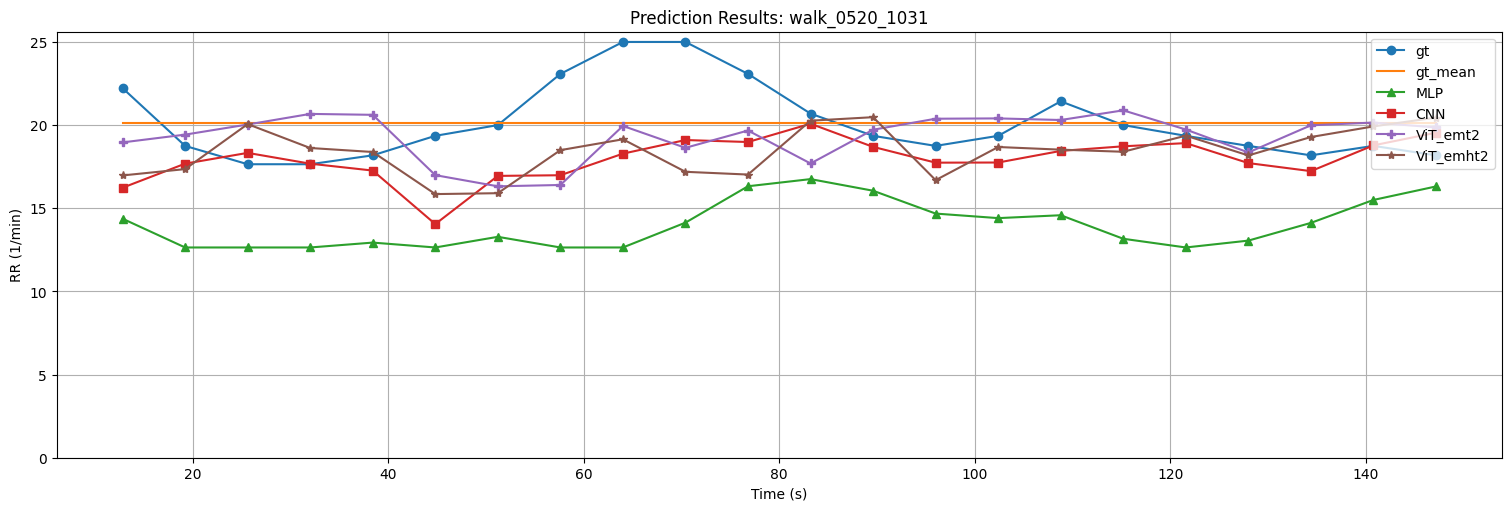

In [14]:
avg_mse_loss, avg_l1_loss, preds = evaluate_models_file(models, file_loader, models_name=models_name_show, gt=gts_file, times=times_file, action_name=action_name)

## Testing Actions

In [16]:
# Load dataset
dataset_dir = "dataset/action"
dataset_name = "7.75P_32"
pkl_test = pickle.load(open(os.path.join(dataset_dir, f'{dataset_name}_test.pkl'), 'rb'))
input_test, gt_test = pkl_test['input'], pkl_test['gt']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

first_key = next(iter(input_test))
num_channels = input_test[first_key].shape[1]
num_freq_bins = input_test[first_key].shape[2]
num_time_steps = input_test[first_key].shape[3]

action_order = ['sit', 'stand', 'walk', 'run']
input_test = {k : input_test[k] for k in action_order}
gt_test = {k : gt_test[k] for k in action_order}
print('Testing data......')
for k, v in input_test.items():
    print(f'action: {k}')
    # print(f'input_test[{k}]:{input_test[k].shape}')
    # print(f'gt_test[{k}]:{gt_test[k].shape}')

Testing data......
action: sit
action: stand
action: walk
action: run


In [17]:
# 2-D spectrogram
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# models_name = ['MLP_7.75P_BC', 'VT_7.75P_BC_emt2', 'VT_7.75P_BC']
# models_name_show = ["MLP", "ViT_emt2", "ViT_emht2"]
# models = [MLP_out1(num_freq_bins, num_time_steps, num_channels=num_channels),
#           VT.ViTRegression(in_channels=num_channels, patch_size=(3, 3), emb_dim=256, mlp_dim=512, device=device),
#           VT.ViTRegression(in_channels=num_channels, patch_size=(3, 3), emb_dim=256, mlp_dim=512, num_heads=8, device=device)]
# for i in range(len(models_name)):
#     models[i].load_state_dict(torch.load(f'./models/{str(models_name[i])}.pt'))

MLP
sit - MSE Loss: 0.0003, L1 Loss: 0.8370 1/min
stand - MSE Loss: 0.0010, L1 Loss: 1.4704 1/min
walk - MSE Loss: 0.0134, L1 Loss: 6.1148 1/min
run - MSE Loss: 0.0034, L1 Loss: 2.7466 1/min

CNN
sit - MSE Loss: 0.0007, L1 Loss: 1.3754 1/min
stand - MSE Loss: 0.0018, L1 Loss: 2.0892 1/min
walk - MSE Loss: 0.0095, L1 Loss: 5.0825 1/min
run - MSE Loss: 0.0022, L1 Loss: 2.3173 1/min

ViT_emt2
sit - MSE Loss: 0.0015, L1 Loss: 1.5225 1/min
stand - MSE Loss: 0.0007, L1 Loss: 1.1765 1/min
walk - MSE Loss: 0.0081, L1 Loss: 4.7109 1/min
run - MSE Loss: 0.0024, L1 Loss: 2.4209 1/min

ViT_emht2
sit - MSE Loss: 0.0009, L1 Loss: 1.4817 1/min
stand - MSE Loss: 0.0014, L1 Loss: 1.7753 1/min
walk - MSE Loss: 0.0072, L1 Loss: 4.4861 1/min
run - MSE Loss: 0.0029, L1 Loss: 2.7195 1/min



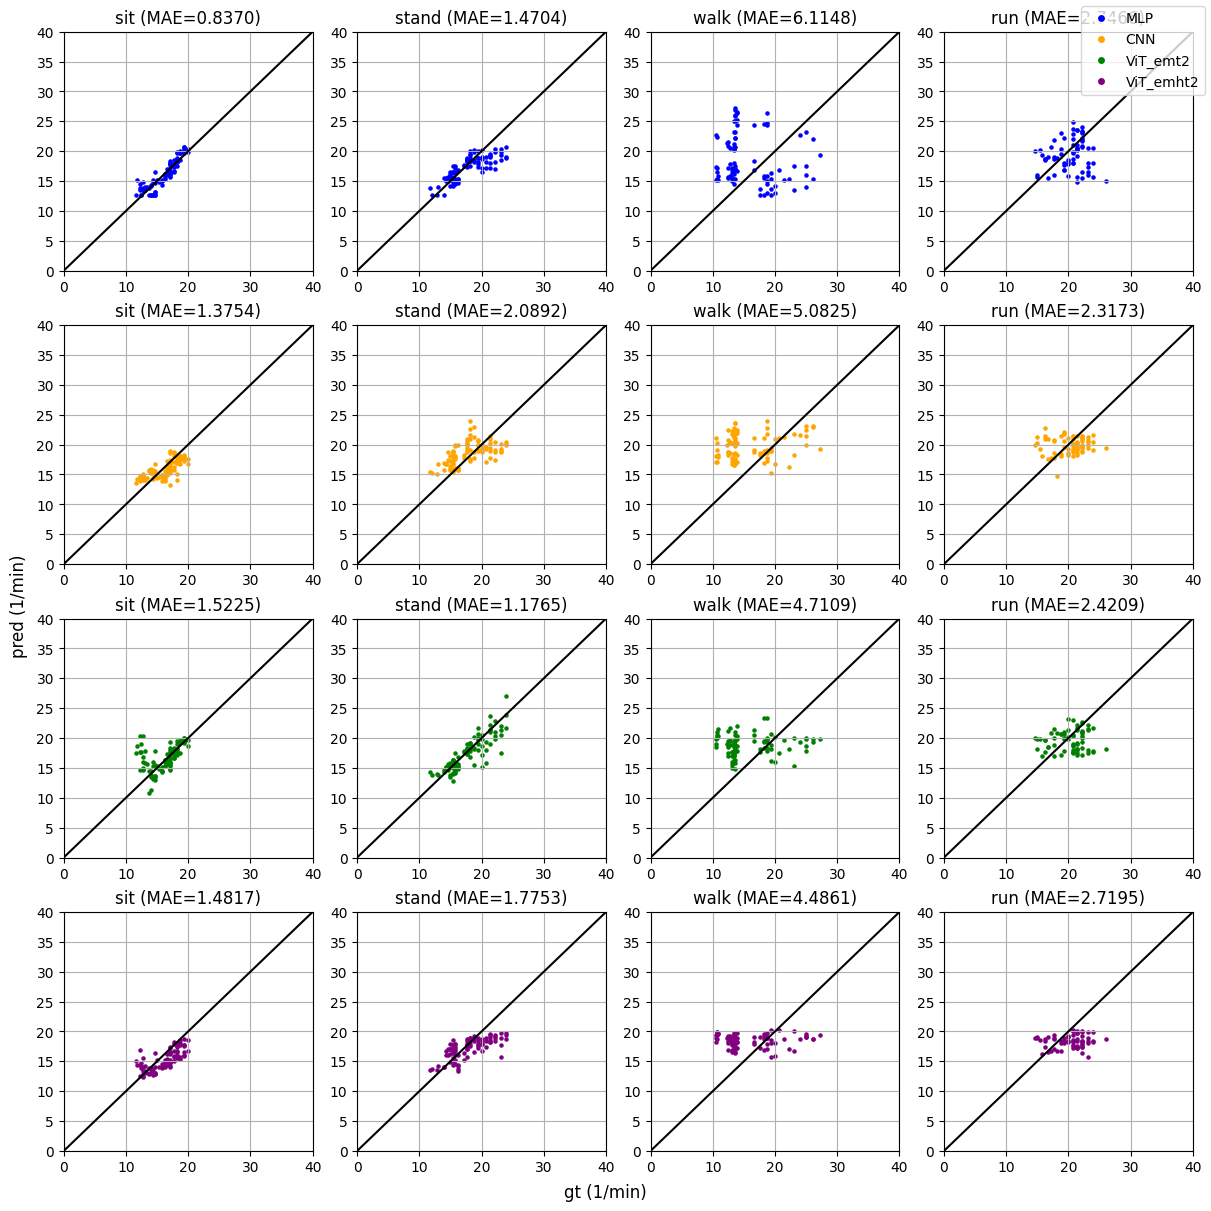

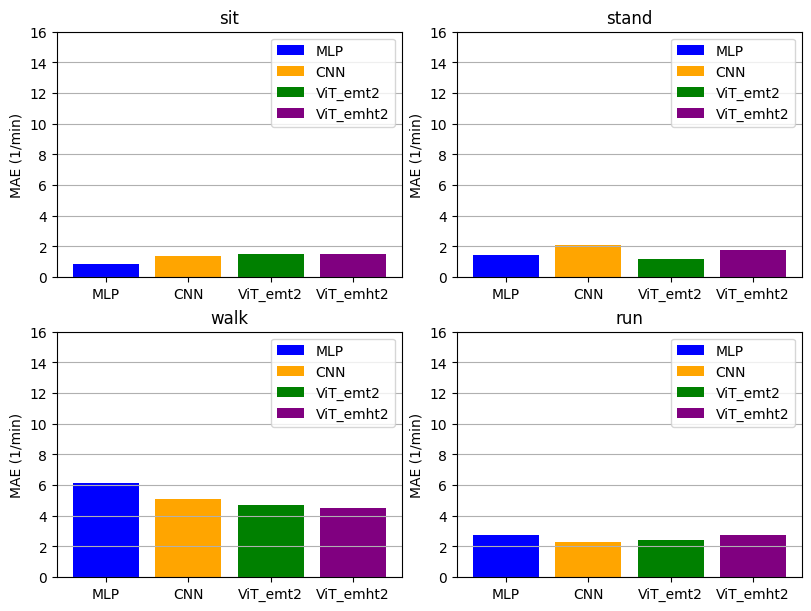

In [18]:
evaluate_models_action(models, input_test, gt_test, models_name=models_name_show, device=device, visualize=True)

MLP
sit - MSE Loss: 0.0003, L1 Loss: 0.8370 1/min E%: 5.4978%
stand - MSE Loss: 0.0010, L1 Loss: 1.4704 1/min E%: 7.7649%
walk - MSE Loss: 0.0134, L1 Loss: 6.1148 1/min E%: 41.4953%
run - MSE Loss: 0.0034, L1 Loss: 2.7466 1/min E%: 13.4710%

CNN
sit - MSE Loss: 0.0007, L1 Loss: 1.3754 1/min E%: 8.8508%
stand - MSE Loss: 0.0018, L1 Loss: 2.0892 1/min E%: 11.9995%
walk - MSE Loss: 0.0095, L1 Loss: 5.0825 1/min E%: 37.2085%
run - MSE Loss: 0.0022, L1 Loss: 2.3173 1/min E%: 11.9851%

ViT_emt2
sit - MSE Loss: 0.0015, L1 Loss: 1.5225 1/min E%: 10.8668%
stand - MSE Loss: 0.0007, L1 Loss: 1.1765 1/min E%: 6.5056%
walk - MSE Loss: 0.0081, L1 Loss: 4.7109 1/min E%: 33.7318%
run - MSE Loss: 0.0024, L1 Loss: 2.4209 1/min E%: 12.1562%

ViT_emht2
sit - MSE Loss: 0.0009, L1 Loss: 1.4817 1/min E%: 9.2932%
stand - MSE Loss: 0.0014, L1 Loss: 1.7753 1/min E%: 9.6067%
walk - MSE Loss: 0.0072, L1 Loss: 4.4861 1/min E%: 32.1227%
run - MSE Loss: 0.0029, L1 Loss: 2.7195 1/min E%: 13.1441%



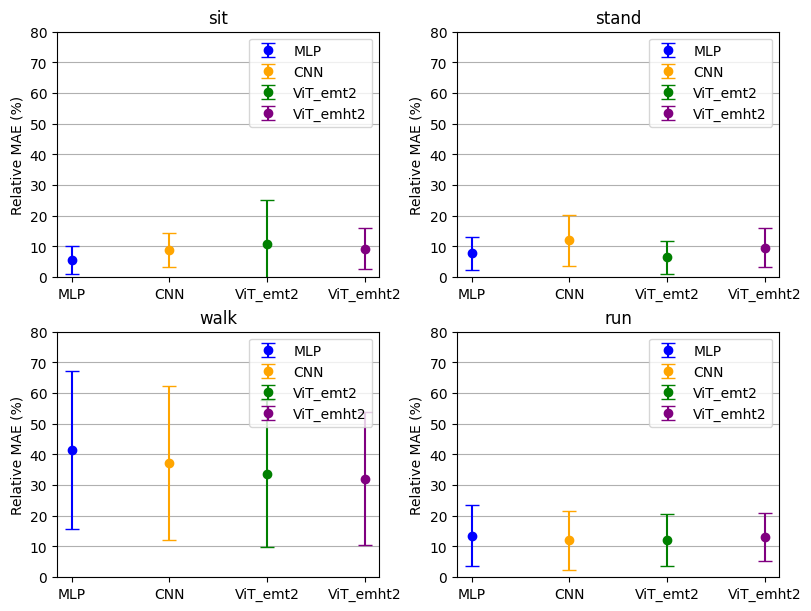

In [19]:
evaluate_models_action_relative(models, input_test, gt_test, models_name=models_name_show, device=device, visualize=True)